In [1]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
import joblib
import shutil


2024-08-08 23:38:34.266000: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-08 23:38:34.285641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 23:38:34.306280: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 23:38:34.312707: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-08 23:38:34.330023: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)  # To find local version of the library


In [3]:
from prediction_model.model import Model
from prediction_model import dataprep


### Import data as pd dataframe
#### Data should contain parameters and max/median/min/std of time

In [36]:
model_name = 'all'

MODEL_PATH = os.path.join(ROOT_DIR, 'prediction_model/models/%s/' % model_name)
DATA_PATH = os.path.join(ROOT_DIR, 'prediction_model/data')


In [37]:
try:
    MODEL_PATH
except:
    pass 

useData = 'Conv' # 'Dense' or 'Conv'
# useData = 'Dense'


In [38]:
if useData == 'Conv':
    df = pd.read_pickle(os.path.join(DATA_PATH,'Data_convolution_%s.pkl' % model_name))
    scaler_filename = os.path.join(MODEL_PATH,'scaler_Conv.save')
elif useData == 'Dense':
    df = pd.read_pickle(os.path.join(DATA_PATH,'Data_dense_%s.pkl' % model_name))
    scaler_filename = os.path.join(MODEL_PATH,'scaler_Dense.save')
else:
    print('useData must be Dense or Conv, currently is %s' % useData)


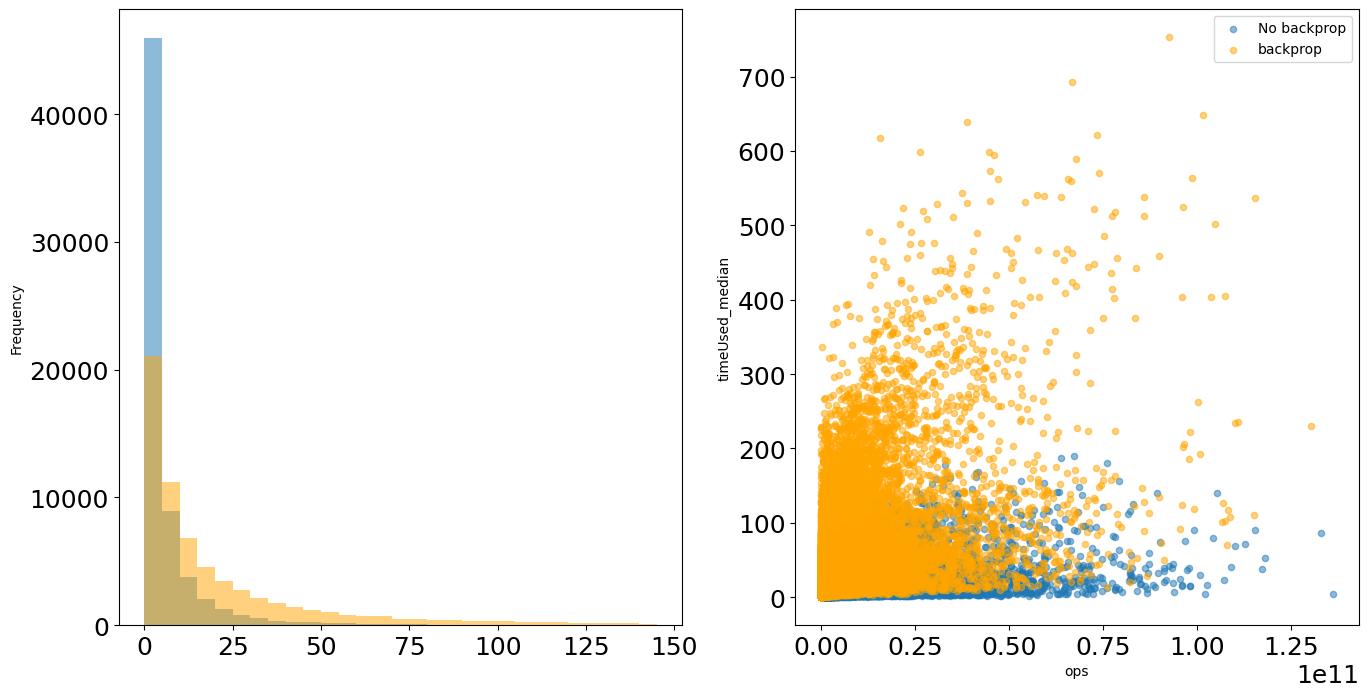

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[16,8])

df[df['opt_None']==1]['timeUsed_median'].plot.hist(bins=np.arange(0,150,5), ax=axes[0], alpha=.5)
df[df['opt_None']==0]['timeUsed_median'].plot.hist(bins=np.arange(0,150,5), ax=axes[0], alpha=.5, color='orange')

df[df['opt_None']==1].plot.scatter(x='ops', y='timeUsed_median', ax=axes[1], alpha=.5, label='No backprop')
df[df['opt_None']==0].plot.scatter(x='ops', y='timeUsed_median', ax=axes[1], alpha=.5, color='orange', label='backprop')

plt.show()

In [40]:
if useData == 'Dense':
    model_name = '%s_dense' %model_name

In [41]:
# # Only forward pass
df = df[df['opt_SGD'] == 1]
model_name = '%s_SGD' % model_name
scaler_filename = "scaler_%s_Conv.save" % model_name


### Generate train, test and validation datasets (80%,10%,10%)
#### Normalise data, generate train, test, validation dataset
#### Use median of time as target parameter

In [42]:
split = [.8, .1, .1]

# Define columns based on the model_name and useData
if model_name == 'all' or model_name.startswith('no_'):
    data_cols_conv = ['batchsize', 'elements_matrix', 'elements_kernel',
                      'channels_in', 'channels_out', 'padding', 'strides', 'use_bias', 
                      'opt_SGD', 'opt_Adadelta', 'opt_Adagrad', 'opt_Momentum', 'opt_Adam', 'opt_RMSProp',
                      'act_relu', 'act_tanh', 'act_sigmoid',
                      'bandwidth', 'cores', 'clock']
    
    data_cols_dense = ['batchsize', 'dim_input', 'dim_output',
                       'opt_SGD', 'opt_Adadelta', 'opt_Adagrad', 'opt_Momentum', 'opt_Adam', 'opt_RMSProp',
                       'act_relu', 'act_tanh', 'act_sigmoid',
                       'bandwidth', 'cores', 'clock']
else:
    data_cols_conv = ['batchsize', 'elements_matrix', 'elements_kernel',
                      'channels_in', 'channels_out', 'padding', 'strides', 'use_bias', 
                      'opt_SGD', 'opt_Adadelta', 'opt_Adagrad', 'opt_Momentum', 'opt_Adam', 'opt_RMSProp',
                      'act_relu', 'act_tanh', 'act_sigmoid']
    
    data_cols_dense = ['batchsize', 'dim_input', 'dim_output',
                       'opt_SGD', 'opt_Adadelta', 'opt_Adagrad', 'opt_Momentum', 'opt_Adam', 'opt_RMSProp',
                       'act_relu', 'act_tanh', 'act_sigmoid']

# Assign the correct columns based on useData
data_cols = data_cols_conv if useData == 'Conv' else data_cols_dense


In [43]:
# Preprocess data
data, time, train, test, validation, scaler = dataprep.data_preprocess(df, data_cols, split)

# Save the scaler
joblib.dump(scaler, scaler_filename)


Size of train dataset: 8736 
Size of test dataset: 1092 
Size of validation dataset: 1092


['scaler_all_SGD_Conv.save']

### Define model

In [44]:
# Set number of neurons based on model_name
if model_name == 'all' or model_name.startswith('no_'):
    num_neurons = [32, 64, 128, 128, 128, 128]
else:
    num_neurons = [32, 64, 128, 128]
    
# Learning rate configuration
lr_initial = 0.1
lr_decay_step = 40


In [45]:
# Assuming data['Train'] is a NumPy array or a similar structure
data_dim = data['Train'].shape[1]

# Using tf.keras.Input to define inputs if creating a model
inputs = tf.keras.Input(shape=(data_dim,), name='model_input')
targets = tf.keras.Input(shape=(1,), name='model_targets')  # Assuming targets are scalar values

# Set the learning rate, reg_constant, and other hyperparameters
learning_rate = 0.1  # You might set this dynamically later
reg_constant = 0.00001
dropout_rate = 0.2
batch_size = 128

# If you're building a model, you can continue with:
# model = tf.keras.Model(inputs=inputs, outputs=outputs)


#### Remove checkpoints and tb output

In [46]:

try:
    folders = [
        f'./checkpoints/{model_name}',
        f'./graphs/prediction/test/{model_name}',
        f'./graphs/prediction/train/{model_name}'
    ]

    for folder in folders:
        if os.path.isdir(folder):
            shutil.rmtree(folder)
            os.makedirs(folder)  # Recreate the directory if necessary

    print('Checkpoints and graph directories cleared.')
except FileNotFoundError:
    print('Nothing to delete. Directory not found.')
except Exception as e:
    print(f'An error occurred: {e}')


Checkpoints and graph directories cleared.


In [47]:
# Define the model
model = Model(
    inputs=inputs,
    targets=targets,  # This will typically be handled during training in TF 2.x
    learning_rate=learning_rate,
    reg_constant=reg_constant,
    dropout_rate=dropout_rate,
    num_neurons=num_neurons,
    lr_initial=lr_initial,
    lr_decay_step=lr_decay_step,
    batch_size=batch_size,
    model_name=model_name
)


In [48]:
# To get predictions, you might call the model directly with inputs
predictions = model(inputs, training=False)


/home/ubuntu/venv/lib/python3.12/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'model_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


#### Given that TensorFlow 2.x handles training differently than TensorFlow 1.x, the concept of model.train_op as used in TensorFlow 1.x is no longer directly applicable. In TensorFlow 2.x, the training process is typically managed through higher-level APIs like model.fit

In [49]:
# Assuming that `data` and `time` are dictionaries containing your training and test data
model.train(data['Train'], time['Train'], data['Test'], time['Test'], 50)


/home/ubuntu/ML-Prediction-AP/mlprediction_createdbyAP/ml-performance-prediction/prediction_model/notebooks
Epoch 0: Train loss 1.620, Test loss 0.990
Epoch 10: Train loss 0.684, Test loss 0.684
Epoch 20: Train loss 0.641, Test loss 0.654
Epoch 30: Train loss 0.614, Test loss 0.637
Epoch 40: Train loss 0.598, Test loss 0.626


In [52]:
folder = os.path.join(ROOT_DIR, 'prediction_model/models/%s/saved_model.keras' %model_name)
if os.path.exists(folder):
    shutil.rmtree(folder)


In [53]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss='mean_squared_error')


In [54]:
model.save(folder)  # Save in the default TensorFlow SavedModel format

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/ubuntu/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


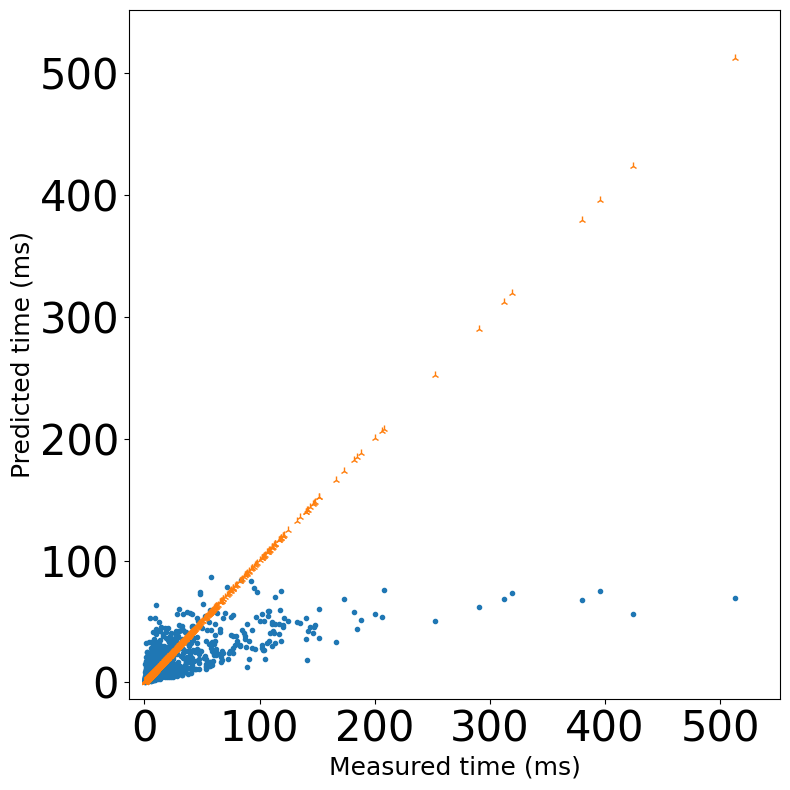

RMS test error = 35.6 ms


In [86]:
# Load the model
restored_model = tf.keras.models.load_model(folder)

# Ensure that data['Test'] and time['Test'] are NumPy arrays
test_data = data['Test']
test_labels = time['Test']

# Get predictions
test_predictions = restored_model.predict(test_data)

# Calculate test loss
loss_fn = tf.keras.losses.MeanSquaredError()
test_loss = loss_fn(test_labels, test_predictions).numpy()

# Calculate RMS test error
RMS_test_error = np.sqrt(np.mean((test_labels - test_predictions)**2))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=[8, 8])
ax.plot(test_labels, test_predictions, '.')
ax.plot(test_labels, test_labels, '2')

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

plt.xlabel('Measured time (ms)', fontsize=18)
plt.ylabel('Predicted time (ms)', fontsize=18)

axlim = max(plt.xlim()[1], plt.ylim()[1])
ax.set_xlim(-axlim * .025, axlim * 1.025)
ax.set_ylim(-axlim * .025, axlim * 1.025)

plt.tight_layout()

# Uncomment and modify the path as needed to save the figure
# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv.png' % model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc.png' % model_name, dpi=300)

plt.show()
print('RMS test error = %.3g ms' % (RMS_test_error))


## Validation

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


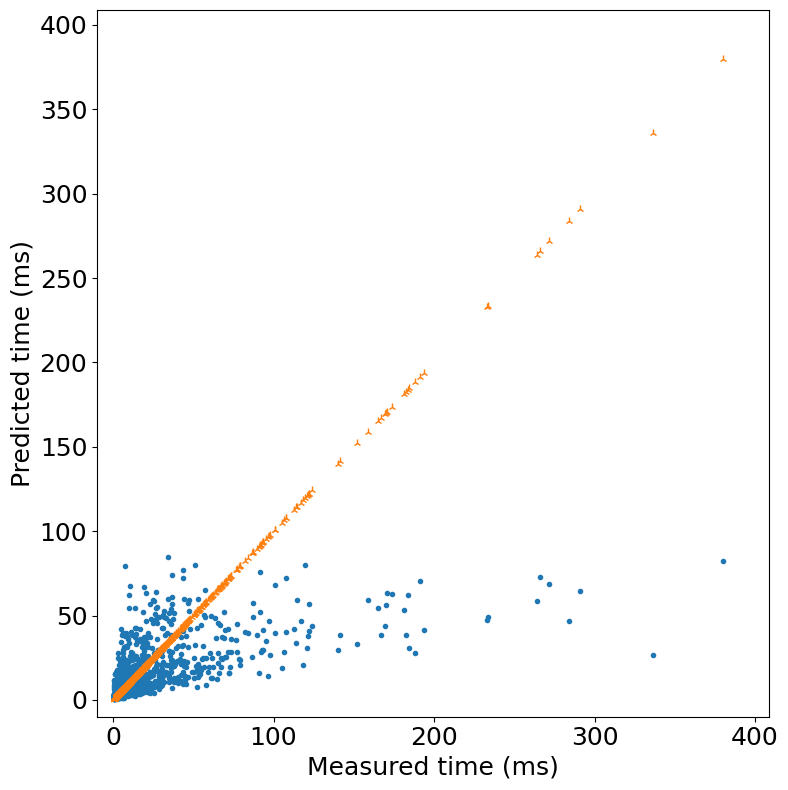

RMS validation error = 31.9 ms
Percentage error = 88%


In [68]:
restored_model = tf.keras.models.load_model(folder)

validation_data = data['Validation']
validation_labels = time['Validation']


validation_predictions = restored_model.predict(validation_data)


# Calculate validation loss
loss_fn = tf.keras.losses.MeanSquaredError()
validation_loss = loss_fn(validation_labels, validation_predictions).numpy()

# Calculate RMS validation error
RMS_validation_error = np.sqrt(np.mean((validation_labels - validation_predictions)**2))
perc_error = np.mean(np.abs(validation_labels-validation_predictions)/validation_predictions)*100


# Plotting
fig, ax = plt.subplots(1, 1, figsize=[8, 8])
ax.plot(validation_labels, validation_predictions, '.')
ax.plot(validation_labels, validation_labels, '2')

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

plt.xlabel('Measured time (ms)', fontsize=18)
plt.ylabel('Predicted time (ms)', fontsize=18)

axlim = max(plt.xlim()[1], plt.ylim()[1])
ax.set_xlim(-axlim * .025, axlim * 1.025)
ax.set_ylim(-axlim * .025, axlim * 1.025)

plt.tight_layout()

# Uncomment and modify the path as needed to save the figure
# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv.png' % model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc.png' % model_name, dpi=300)

plt.show()
print('RMS validation error = %.3g ms' % (RMS_validation_error))
print('Percentage error = %.3g%%' %(perc_error))

## Creating a Linear Regression for Comparison

In [69]:
df_validation = df.iloc[validation]
df_train = df.iloc[train]

In [78]:
linreg = linear_model.LinearRegression()

In [79]:
x_train = df_train[['batchsize','elements_matrix','elements_kernel',
                'channels_in','channels_out','padding','strides','use_bias','ops']].values   
y_train = df_train['timeUsed_median'].values   # time

x_valid = df_validation[['batchsize','elements_matrix','elements_kernel',
                'channels_in','channels_out','padding','strides','use_bias','ops']].values
y_valid = df_validation['timeUsed_median'].values   # time

In [80]:
linreg.fit(x_train, y_train)

LinearRegression()

In [81]:
lp = linreg.predict(x_valid)

In [82]:
linreg.coef_

array([ 8.39605108e-01,  1.47978051e-04,  2.21005030e-01,  6.70602320e-03,
        3.79472162e-03,  1.86014035e+00, -4.89410720e+00,  1.50420603e+00,
        2.65263645e-09])

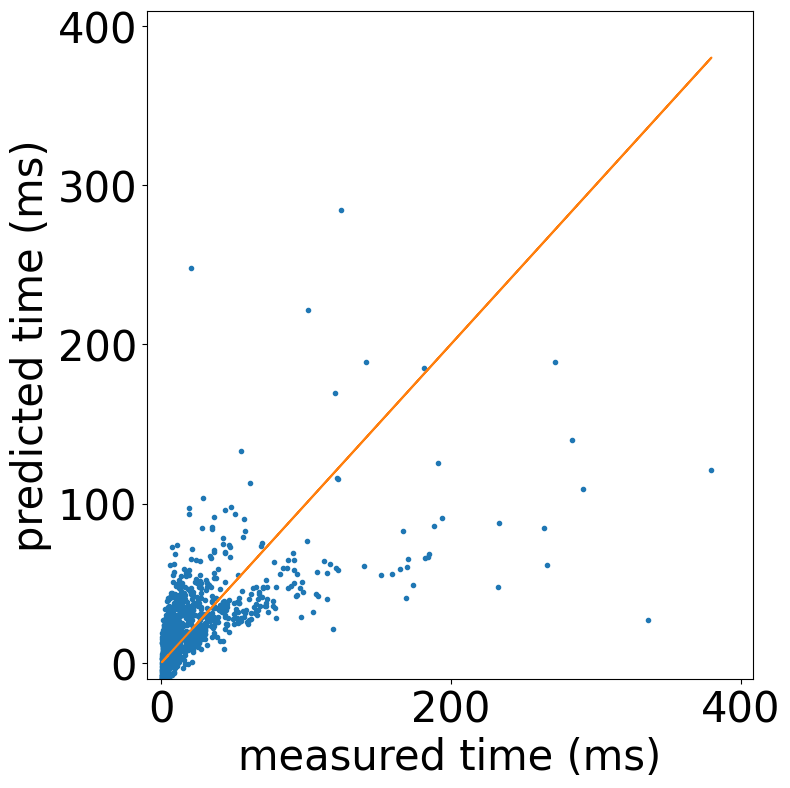

In [83]:
labels = [.2,.3,.4,.5,1]

RMS_vadiation_error=np.sqrt(np.mean((y_valid-lp)**2))
perc_error = np.mean(np.abs(y_valid-lp)/y_valid)*100
fig,ax = plt.subplots(1,1,figsize=[8,8])

ax.plot(y_valid,lp,'.')

ax.plot(y_valid,y_valid)

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())


matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

plt.xlabel('measured time (ms)',fontsize=30)
plt.ylabel('predicted time (ms)',fontsize=30)

#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

# ax.xaxis.set_ticks([0,25,50,75,100,125])

plt.tight_layout()


# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv_linearreg.png' %model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc_linearreg.png' %model_name, dpi=300)

plt.show()

In [84]:
RMS_vadiation_error

30.1682304817573

In [85]:
perc_error

270.43345279676805